In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder  
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np
import nltk
#import tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')

2023-12-22 19:38:12.174116: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 19:38:12.174184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 19:38:12.175795: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 19:38:12.302390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /home/ome

True

In [2]:
df = pd.read_csv('../data/darija_reviews_cleaned.csv')
X = df['cleaned_review'].astype(str).values
y = df['rating'].values

In [3]:
df['cleaned_review'] = df['cleaned_review'].astype(str)

tokenized_reviews = [word_tokenize(review) for review in df['cleaned_review']]

model_word2vec = Word2Vec(sentences=tokenized_reviews, vector_size=1000, window=5, min_count=1, workers=4)

model_word2vec.save("output/word2vec.model")

In [4]:
model_word2vec = Word2Vec.load("output/word2vec.model")

tokenized_reviews = [word_tokenize(review) for review in df['cleaned_review']]

review_vectors = [np.mean([model_word2vec.wv[token] for token in review], axis=0) for review in tokenized_reviews]
review_vectors = np.array(review_vectors)
review_vectors_word2vec = np.nan_to_num(review_vectors)



In [5]:
tfidf = TfidfVectorizer()

tfidf.fit(df['cleaned_review'])

review_vectors_tfidf = tfidf.transform(df['cleaned_review']).toarray()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(review_vectors_tfidf, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape

(732, 1324)

In [60]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(X_train.shape[0], 128),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1,activation='linear')
])

conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(1e-4),
                   metrics=['mse'])

conv_model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test), verbose=1,use_multiprocessing=True)

Epoch 1/60
23/23 [==============================] - 2s 30ms/step - loss: 18.3778 - mse: 18.3778 - val_loss: 18.2423 - val_mse: 18.2423
Epoch 2/60
23/23 [==============================] - 0s 14ms/step - loss: 16.3997 - mse: 16.3997 - val_loss: 16.0444 - val_mse: 16.0444
Epoch 3/60
23/23 [==============================] - 0s 14ms/step - loss: 14.0439 - mse: 14.0439 - val_loss: 13.3051 - val_mse: 13.3051
Epoch 4/60
23/23 [==============================] - 0s 14ms/step - loss: 11.1716 - mse: 11.1716 - val_loss: 10.1083 - val_mse: 10.1083
Epoch 5/60
23/23 [==============================] - 0s 14ms/step - loss: 7.9644 - mse: 7.9644 - val_loss: 6.6964 - val_mse: 6.6964
Epoch 6/60
23/23 [==============================] - 0s 13ms/step - loss: 4.8686 - mse: 4.8686 - val_loss: 3.7695 - val_mse: 3.7695
Epoch 7/60
23/23 [==============================] - 0s 14ms/step - loss: 2.6399 - mse: 2.6399 - val_loss: 1.9749 - val_mse: 1.9749
Epoch 8/60
23/23 [==============================] - 0s 13ms/step - 

Lowest validation loss: 1.2199201583862305
Epoch of lowest validation loss: 55


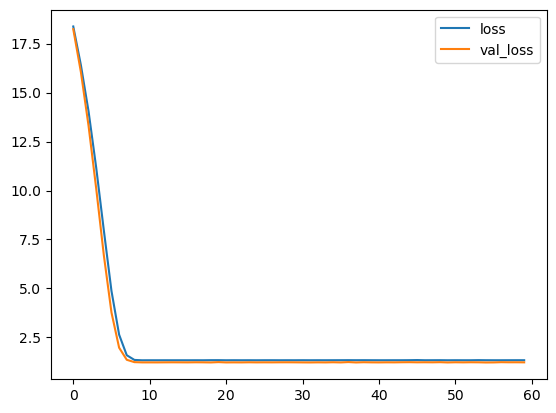

In [62]:
from matplotlib import pyplot as plt

plt.plot(conv_model.history.history['loss'], label='loss')
plt.plot(conv_model.history.history['val_loss'], label='val_loss')
plt.legend()
print(f'Lowest validation loss: {min(conv_model.history.history["val_loss"])}')
print(f'Epoch of lowest validation loss: {np.argmin(conv_model.history.history["val_loss"])+1}')

6/6 [==============================] - 0s 16ms/step


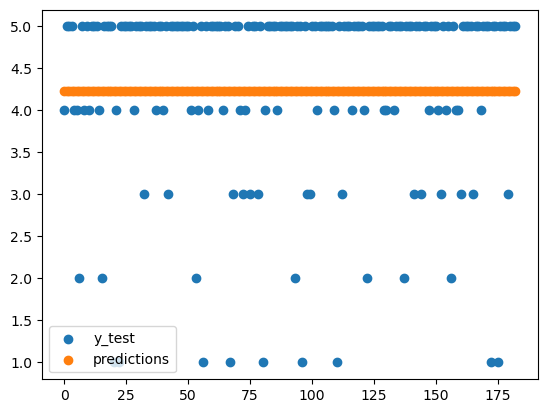

In [63]:
predictions = conv_model.predict(X_test)

plt.scatter(range(len(y_test)), y_test, label='y_test')
plt.scatter(range(len(predictions)), predictions, label='predictions')
plt.legend()

# LSTM

In [85]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(X_train.shape[0], 128),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1,activation='linear')
])

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['mse'])

lstm_model.summary()

lstm_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1,use_multiprocessing=True)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 128)         93696     
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_67 (Dense)            (None, 64)                8256      
                                                                 
 dense_68 (Dense)            (None, 32)                2080      
                                                                 
 dense_69 (Dense)            (None, 1)                 33        
                                                                 
Total params: 235649 (920.50 KB)
Trainable params: 23

1/1 [==============================] - 0s 39ms/step


array([[4.250547]], dtype=float32)

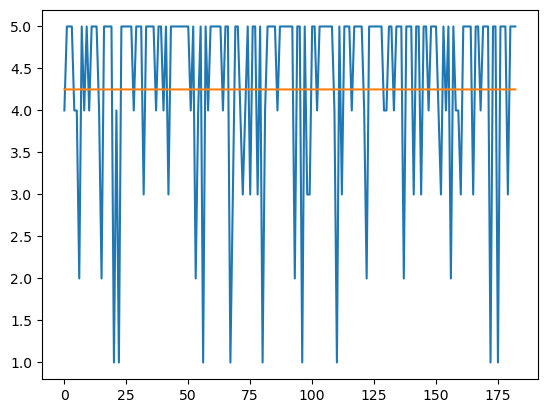

In [86]:
predictions = lstm_model.predict(X_test)

plt.plot( y_test, label='y_test')
plt.plot( predictions, label='predictions')

text = "3jbni produit mzyan"
text = tfidf.transform([text]).toarray()
lstm_model.predict(text)

In [87]:
# Tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(vocab_size)

1352


In [88]:
# Create sequences
sequences = tokenizer.texts_to_sequences(X)
# get sequence max length
max_length = max([len(s.split()) for s in X])
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
len(padded[0])

42

In [101]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2, random_state=42)


In [103]:
y_test.shape

(183,)

In [104]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((732, 42), (732,), (183, 42), (183,))

In [117]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input


# Create the model
dense_network = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(vocab_size+1, 32, input_length=max_length),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16, )),
   # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
   #tf.keras.layers.Flatten(),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
   # tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='linear')
])



opt = Adam()

# Compile the model
dense_network.compile(loss=tf.keras.losses.MeanSquaredError(),
                     optimizer=opt,
                     metrics=['mse'])

# Train the model
history = dense_network.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))


Epoch 1/100
23/23 [==============================] - 2s 70ms/step - loss: 17.9354 - mse: 17.9354 - val_loss: 15.9219 - val_mse: 15.9219
Epoch 2/100
23/23 [==============================] - 2s 71ms/step - loss: 16.5948 - mse: 16.5948 - val_loss: 15.3426 - val_mse: 15.3426
Epoch 3/100
23/23 [==============================] - 1s 49ms/step - loss: 16.1912 - mse: 16.1912 - val_loss: 14.6439 - val_mse: 14.6439
Epoch 4/100
23/23 [==============================] - 1s 26ms/step - loss: 15.3798 - mse: 15.3798 - val_loss: 13.5272 - val_mse: 13.5272
Epoch 5/100
23/23 [==============================] - 1s 28ms/step - loss: 14.3131 - mse: 14.3131 - val_loss: 12.8048 - val_mse: 12.8048
Epoch 6/100
23/23 [==============================] - 1s 25ms/step - loss: 14.6837 - mse: 14.6837 - val_loss: 12.0140 - val_mse: 12.0140
Epoch 7/100
23/23 [==============================] - 1s 28ms/step - loss: 13.6211 - mse: 13.6211 - val_loss: 11.7502 - val_mse: 11.7502
Epoch 8/100
23/23 [=============================

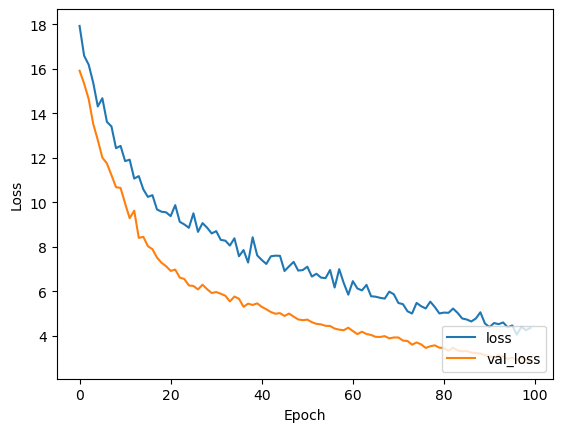

In [118]:
import matplotlib.pyplot as plt

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')

# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend(loc='lower right')


6/6 [==============================] - 0s 2ms/step


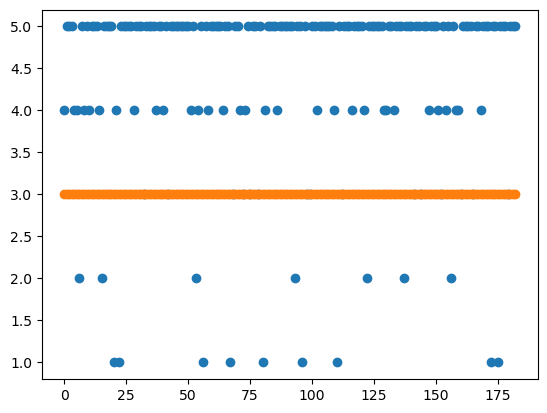

In [119]:
predictions = dense_network.predict(X_test)

plt.scatter(range(len(y_test)), y_test, label='y_test')
plt.scatter(range(len(predictions)), np.round(predictions), label='predictions')

In [121]:
#predict

text = 'le produit est zwin bzaaf'
input = tokenizer.texts_to_sequences([text])
input = pad_sequences(input, maxlen=max_length, padding='post', truncating='post')

dense_network.predict(input)

1/1 [==============================] - 0s 17ms/step


array([[3.1677506]], dtype=float32)